#  Прогнозирование заказов такси

_____
**Описание исследования.**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).
_____
**Цель исследования.**
Разработка системы предсказания объема заказа
_____
**Исходные данные.**
    
Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).
______





<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Проведем-ресемплирование-по-дню,-построив-график-ежедневного-количества-заказов" data-toc-modified-id="Проведем-ресемплирование-по-дню,-построив-график-ежедневного-количества-заказов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><em>Проведем ресемплирование по дню, построив график ежедневного количества заказов</em></a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг-CatBoost" data-toc-modified-id="Градиентный-бустинг-CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Градиентный бустинг CatBoost</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>


## Подготовка

In [1]:
!pip install prophet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import  make_pipeline

from catboost import CatBoostRegressor, cv, train
from prophet import Prophet

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])   

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
#проверим на пропуски 
df.isnull().sum()

num_orders    0
dtype: int64

In [9]:
#проверим в хронологическом ли порядке расположены значения индекса
df.index.is_monotonic_increasing 

True

In [10]:
# ресемплируем данные по одному часу
df = df.resample('1H').sum()

In [11]:
#проверим
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
#проверим в хронологическом ли порядке расположены значения индекса
df.index.is_monotonic_increasing 

True

Даты у нас расположены в хронологическом порядке. Посмотрим распределение знаений в нашей таблице

In [14]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


▪ минимальное количесво заказов в час - 0

▪ максимальное - 462

▪ в среднем 84 заказа в час

## Анализ

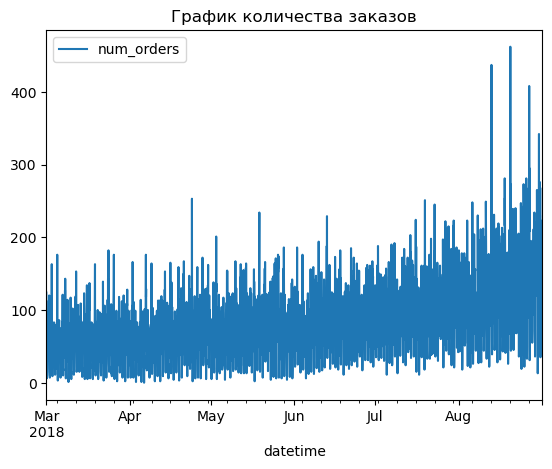

In [15]:
df.plot()
plt.title('График количества заказов')
plt.show()

In [16]:
#найдем скользящее среднее и скользящее стандартное отклонение 
#для этого создадим скопируем нашу таблицу
df_new = df.copy()
df_new['mean'] = df_new['num_orders'].rolling(50).mean()
df_new['std'] = df_new['num_orders'].rolling(50).std()


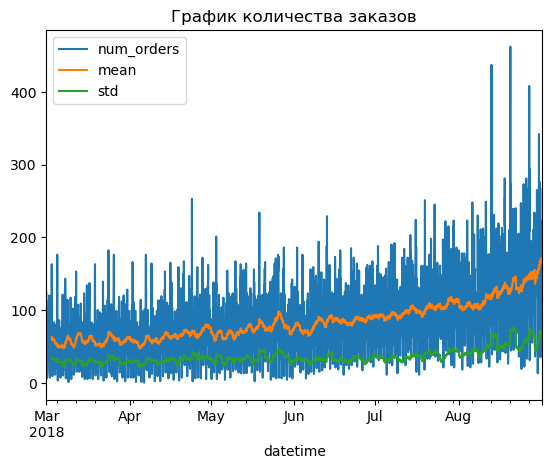

In [17]:
df_new.plot()
plt.title('График количества заказов')
plt.show()

среднее значение и отклонение не сильно меняютсяю внешне график стационарный. Проведем дополнгительно тест Дики-Фуллера

In [18]:
adfuller(df)

(-3.068924289027958,
 0.028940051402612743,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

In [19]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


**Мы провели тест Дики-Фуллера на таблице ресемплированном по часу. p-value меньше 0.05. значит мы можем отвергнуть нулевую гипотезу наш временной ряд стационарный**

> разложим наш ряд на 3 компонента: тред, сезонная составляющая и остаток декомпозиции

In [20]:
decomposed = seasonal_decompose(df)

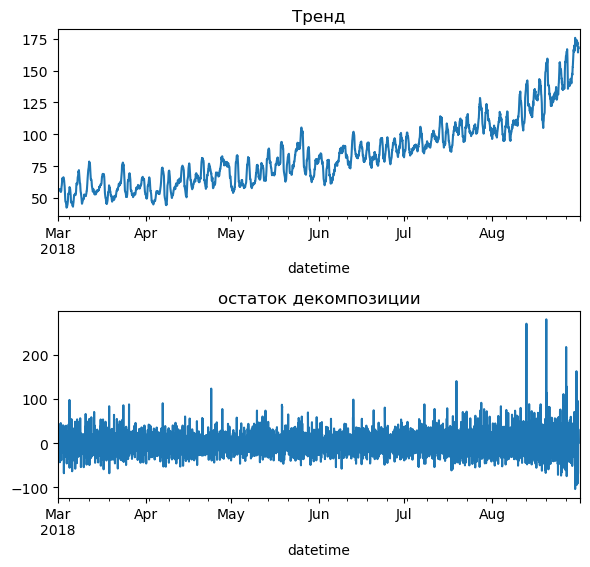

In [21]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
# plt.subplot(312)
# decomposed.seasonal.plot(ax=plt.gca())
# plt.title('сезонная составляющая')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('остаток декомпозиции')
plt.tight_layout()

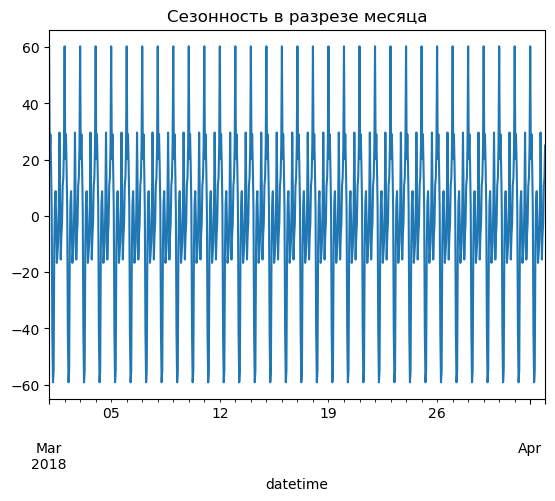

In [22]:
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Сезонность в разрезе месяца')
plt.show()

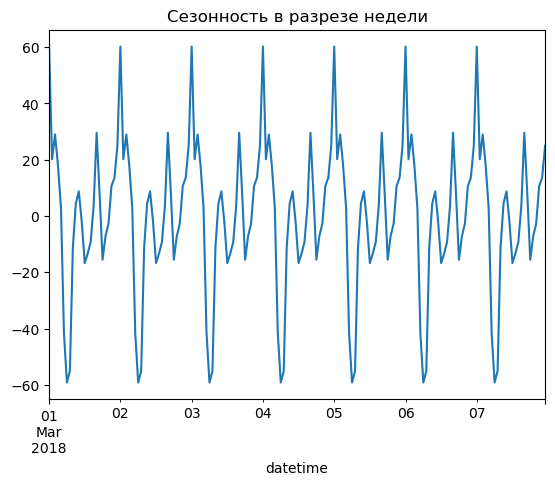

In [23]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Сезонность в разрезе недели')
plt.show()

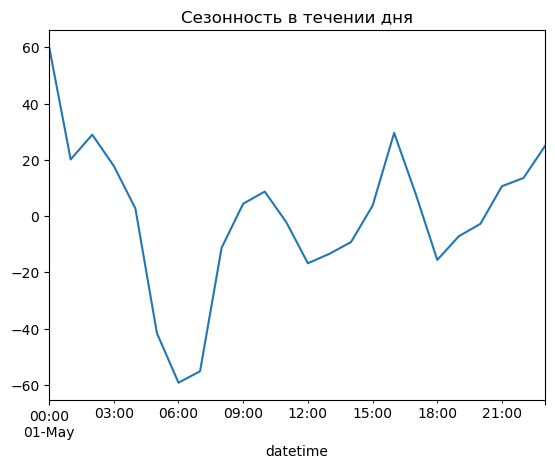

In [24]:
decomposed.seasonal['2018-05-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Сезонность в течении дня')
plt.show()

**Вывод:** наблюдаем повышение тренда с начала июля. не удивительно, лето сезон отпусков.

График сезонности показывает повышенный спрос с 18:00 до 00:00 далее до 6 утра спрос пониженный. 

### *Проведем ресемплирование по дню, построив график ежедневного количества заказов*

In [26]:
#создадим новую таблицу
try:
    df_day = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df_day = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])   

In [27]:
df_day = df_day.resample('1D').sum()

In [28]:
#найдем скользящее среднее и скользящее стандартное отклонение 
df_day['mean'] = df_day['num_orders'].rolling(5).mean()
df_day['std'] = df_day['num_orders'].rolling(5).std()

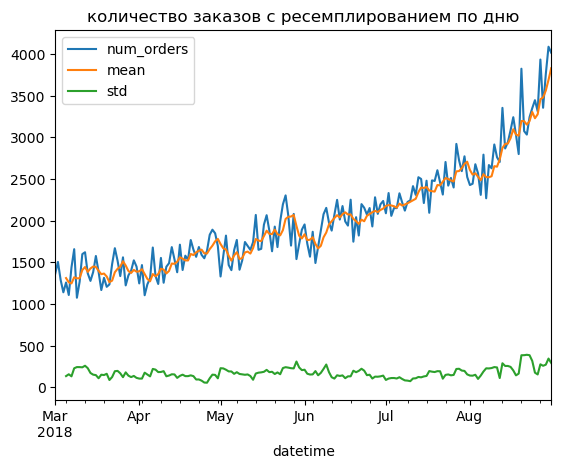

In [29]:
df_day.plot()
plt.title('количество заказов с ресемплированием по дню')
plt.show()

Можем наблюдать рост среднее значения. стандартное отклонение как и на прошлом  не сильно меняется. Внешне график выглядит не стационарным. Проведем тест Дики-Фуллера

In [30]:
adfuller(df_day['num_orders'])

(3.7287913115649953,
 1.0,
 13,
 170,
 {'1%': -3.469413468959902,
  '5%': -2.8786964197028295,
  '10%': -2.5759166089965397},
 2198.369618218204)

In [31]:
ts = df_day['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Ряд нестационарный


**Мы провели тест Дики-Фуллера на таблице ресемплированном по дню. p-value больше 0.05. значит мы не можем отвергнуть нулевую гипотезу.**

**наш временной ряд не стационарный**

In [32]:
decomposed_day = seasonal_decompose(df_day['num_orders'])

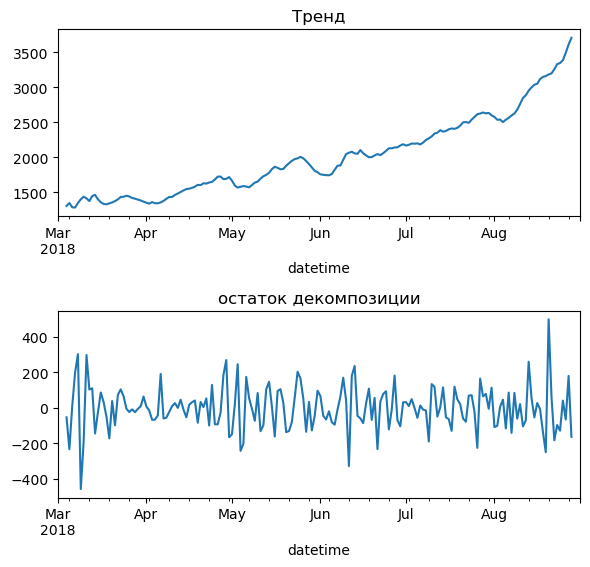

In [33]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('остаток декомпозиции')
plt.tight_layout()

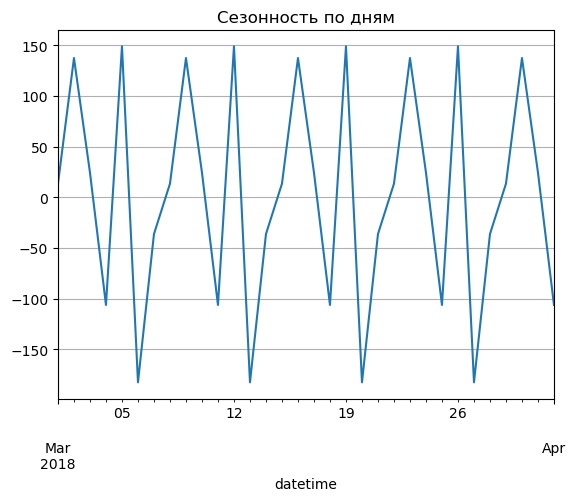

In [34]:
decomposed_day.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca(), grid=True)
plt.title('Сезонность по дням')
plt.show()

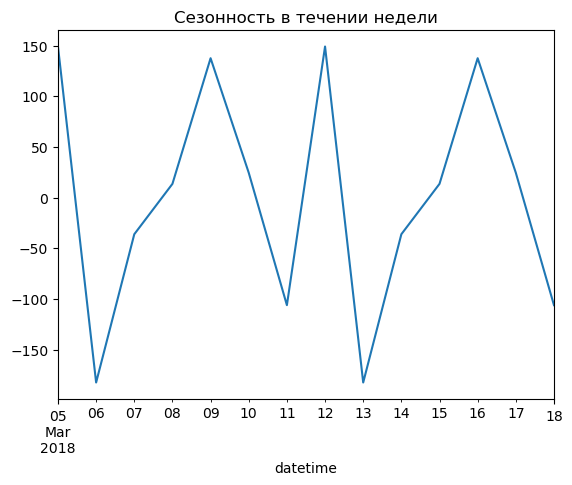

In [35]:
#возьмем срез с 5 марта. т.к. это понедельник и нам удобно будет анализировать
decomposed_day.seasonal['2018-03-05':'2018-03-18'].plot(ax=plt.gca())
plt.title('Сезонность в течении недели')
plt.show()

**Вывод:** в графике сезонности в течении недели можем заметить повышенный спрос по пятницам и понедельникам. В то же время самый не популярный день для авиаперелетов - вторник

### Вывод

Мы провели ресемплирование по часу, нашли скользящее среднее и стандартное отклонение.
Дополнительно провели тест Дики-Фуллера, который показал, что наш временной ряд стационарный.

Разложили наш ряд на 3 компонента: тред, сезонная составляющая и остаток декомпозиции. Посмотрели сезонность в рамках месяца, недели и дня. 

То же самое провели с таблицей ресемплированной по дню. 

Тред повышается с начала лета. Предположили, что данный факт связан с сезоном отпусков.

График сезонности показывает повышенный спрос по понедельникам и пятницам и с 18:00 до 00:00. 
Самые не популярные дни и время это вторники и 6 утра. 

## Обучение

In [36]:
#напишем функцию для создания признаков
def make_features(data, max_lag, rolling_mean_size):
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [37]:
make_features(df, 4, 6)
print(df.head())

                     num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1  124.0    NaN    NaN    NaN   
2018-03-01 02:00:00          71          3     2   85.0  124.0    NaN    NaN   
2018-03-01 03:00:00          66          3     3   71.0   85.0  124.0    NaN   
2018-03-01 04:00:00          43          3     4   66.0   71.0   85.0  124.0   

                     rolling_mean  
datetime                           
2018-03-01 00:00:00           NaN  
2018-03-01 01:00:00           NaN  
2018-03-01 02:00:00           NaN  
2018-03-01 03:00:00           NaN  
2018-03-01 04:00:00           NaN  


In [38]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [39]:
train = train.dropna()

In [40]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

In [41]:
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [42]:
display(train_features.shape)
display(train_target.shape)
display(test_features.shape)
display(test_target.shape)

(3968, 7)

(3968,)

(442, 7)

(442,)

### Линейная регрессия

In [43]:
%%time
model_lr = LinearRegression()
model_lr.fit(train_features, train_target)
pred_train_lr = model_lr.predict(train_features)

CPU times: total: 0 ns
Wall time: 15.2 ms


In [44]:
print("RMSE обучающей выборки на линейной регрессии:", (mean_squared_error(train_target, pred_train_lr))**.5)

RMSE обучающей выборки на линейной регрессии: 31.597665824016342


### Случайный лес

In [45]:
tscv = TimeSeriesSplit()

In [46]:
%%time

model_rf = RandomForestRegressor()
params_rf = {"n_estimators": range(10, 101, 10),
             "max_depth":range(1, 101, 2)}
grid_rf = GridSearchCV(model_rf, param_grid = params_rf, scoring='neg_mean_squared_error', cv=tscv)
grid_rf.fit(train_features, train_target)

CPU times: total: 10min 39s
Wall time: 10min 40s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 101, 2),
                         'n_estimators': range(10, 101, 10)},
             scoring='neg_mean_squared_error')

In [47]:
print("Лучшие модели")
print(grid_rf.best_params_)

Лучшие модели
{'max_depth': 43, 'n_estimators': 90}


In [48]:
print('RMSE для случайного леса =', (grid_rf.best_score_.mean() * -1) ** .5)

RMSE для случайного леса = 26.47327056463228


### Градиентный бустинг CatBoost


In [49]:
%%time
model_cat = CatBoostRegressor()
params_cat = [{'learning_rate':[0.1, 0.5, 0.8],
         'random_state':[12345],
         'depth': [4, 6, 10],
         'l2_leaf_reg': [1, 3, 5, 7, 9],
         'verbose':[False]}]
grid_cat = GridSearchCV(model_cat, params_cat, scoring='neg_mean_squared_error', cv=tscv)
grid_cat.fit(train_features, train_target)

CPU times: total: 17min 21s
Wall time: 13min 13s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000290A5814F50>,
             param_grid=[{'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5, 7, 9],
                          'learning_rate': [0.1, 0.5, 0.8],
                          'random_state': [12345], 'verbose': [False]}],
             scoring='neg_mean_squared_error')

In [50]:
print("Лучшие модели")
print(grid_cat.best_params_)

Лучшие модели
{'depth': 6, 'l2_leaf_reg': 9, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}


In [51]:
print('RMSE для CatBoostRegressor =', (grid_cat.best_score_.mean() * -1) ** .5)

RMSE для CatBoostRegressor = 27.28774604965005


### Prophet

In [52]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])   

In [53]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [54]:
ts_train, ts_test = train_test_split(data, shuffle=False, test_size=0.1)
    
prophet_train = pd.DataFrame()
prophet_train['ds'] = ts_train.index
prophet_train['y'] = ts_train.values.astype('int')

prophet_test = pd.DataFrame()
prophet_test['ds'] = ts_test.index
prophet_test['y'] = ts_test.values.astype('int')

In [55]:
# код обучение моделей
prophet_1 = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
prophet_1.fit(prophet_train)

14:36:26 - cmdstanpy - INFO - Chain [1] start processing
14:36:28 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
# С помощью вспомогательной функции make_future_dataframe создаем dataframe,
# который содержит все исторические временные точки и плюс количество дней в тестовой (валидационной) выборке,
# для которых мы хотели построить прогноз.

# Для того, чтобы построить прогноз вызываем у модели функцию predict и передаем в нее полученный на предыдущем шаге future

future = prophet_1.make_future_dataframe(periods=prophet_test.shape[0], freq='H')

forecast = prophet_1.predict(future)

In [89]:
prophet_prediction = forecast.head(prophet_train.shape[0])[['yhat_upper']]

prophet_prediction.index = ts_train.index

In [90]:
print(f"prophet: {mean_squared_error(prophet_train['y'], prophet_prediction)**.5:.3}")

prophet: 10.4


Мы обучили несколько моделей: 
- Линейную регрессию;
- Случайный лес;
- Градиентный бустинг CatBoost;
- Prophet

У Prophet оказался наилучший результат - RMSE для prophet = 10.4


### Тестирование лучшей модели

In [69]:
prophet_prediction = forecast.tail(prophet_test.shape[0])[['yhat_upper']]

prophet_prediction.index = ts_test.index

In [81]:
print(f"prophet: {mean_squared_error(prophet_test['y'], prophet_prediction)**.5:.3}")

prophet: 20.8


<Axes: xlabel='datetime', ylabel='num_orders'>

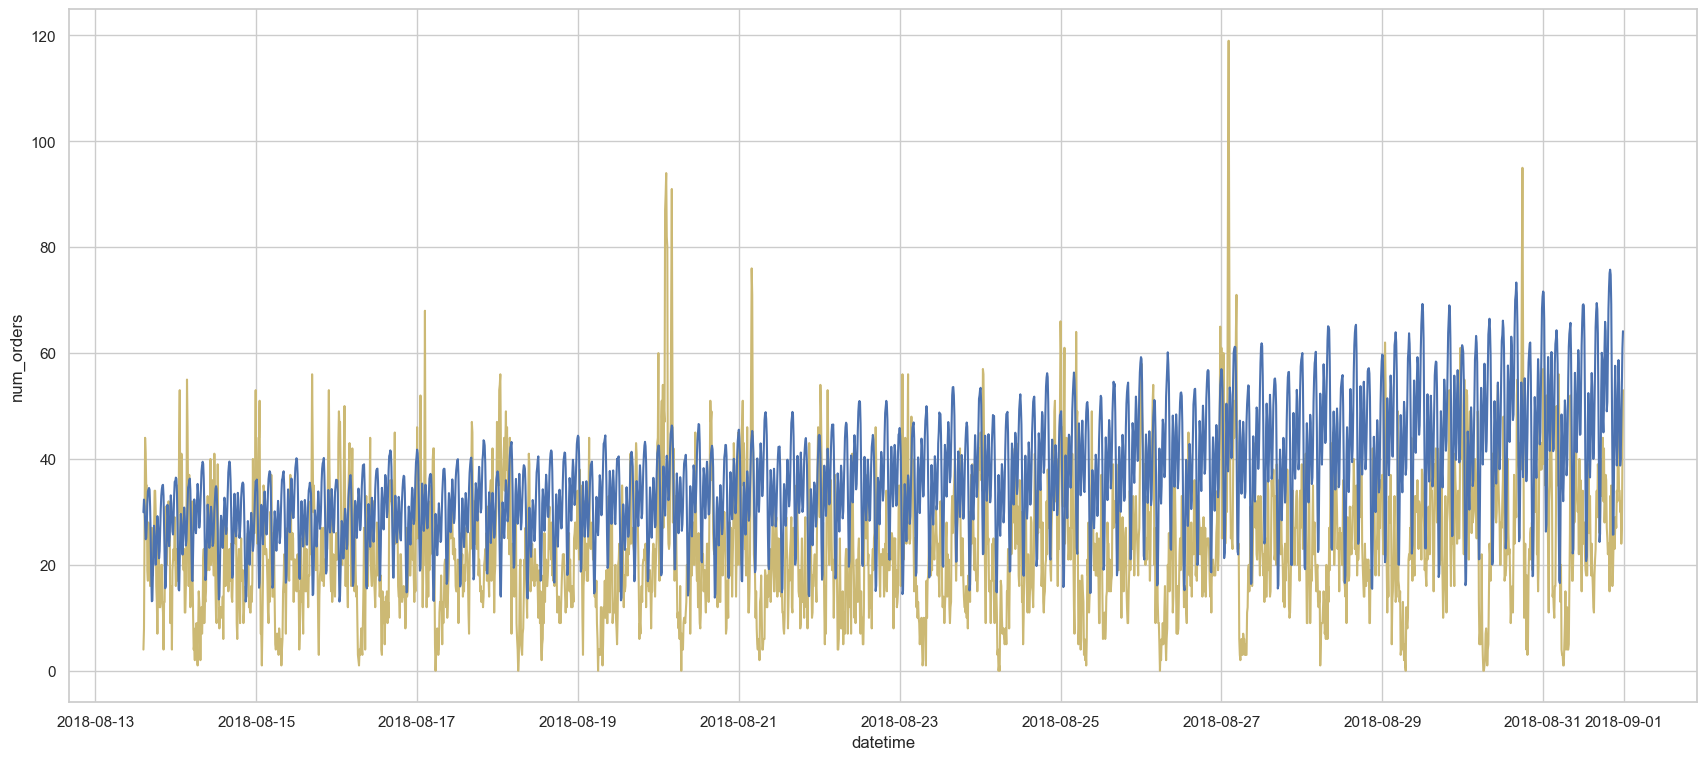

In [80]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(21,9))
sns.lineplot(x=ts_test.index, y=ts_test['num_orders'], ax=ax, color='y')
sns.lineplot(x=prophet_prediction.index, y=prophet_prediction['yhat_upper'], ax=ax, color='b')

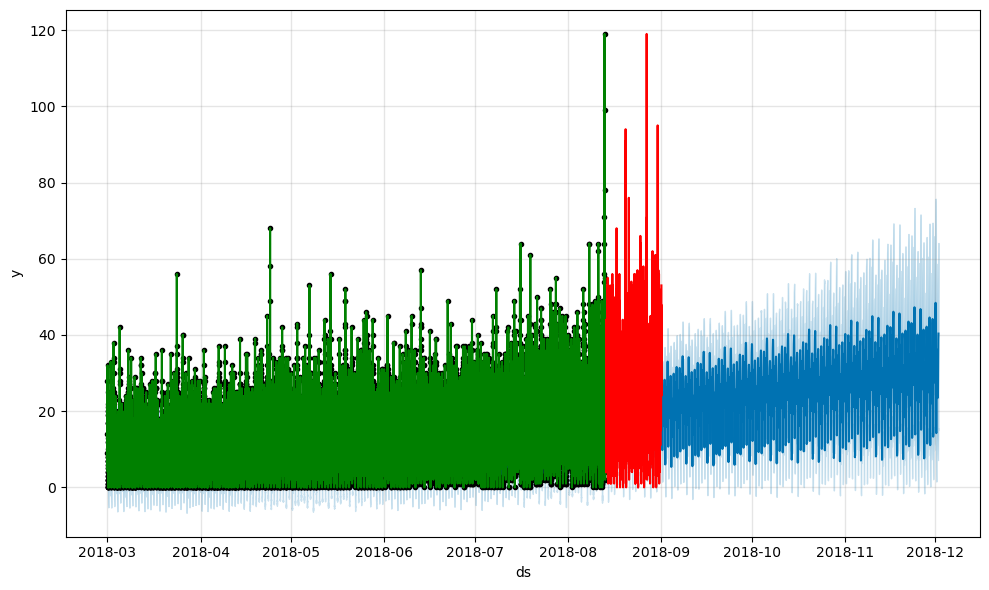

In [57]:
# Нас интересуют следующие столбцы:
# ds, yhat (предсказание), 
# yhat_lower (нижняя граница доверительного интервала), yhat_upper (верхняя граница доверительного интервала)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_1.plot(forecast)
plt.plot(ts_train, color='g')
plt.plot(ts_test, color='r')

## Вывод

Мы подготовили и проанализировали нашу таблицу перед обучением:

▪ минимальное количесво заказов в час - 0

▪ максимальное - 462

▪ в среднем 84 заказа в час

Провели ресемплирование по часу, нашли скользящее среднее и стандартное отклонение.
Дополнительно провели тест Дики-Фуллера, который показал, что наш временной ряд стационарный.

Разложили наш ряд на 3 компонента: тред, сезонная составляющая и остаток декомпозиции. Посмотрели сезонность в рамках месяца, недели и дня. 

То же самое провели с таблице ресемплированной по дню. 

**Тред повышается с начала лета.** Придположили, что данный факт связан с сезоном отпусков.

**График сезонности показывает повышенный спрос по понедельникам и пятницам и с 18:00 до 00:00. 
Самые не популярные дни и время это вторники и 6 утра.**

Обучили несколько моделей: 
- Линейную регрессию;
- Случайный лес;
- Градиентный бустинг CatBoost;
- Prophet

У Prophet оказался наилучший результат 
- RMSE для тренировочноый выборки = 10.4
- RMSE для тестовой выборки = 20.8

Требование заказчика соблюдено: RMSE меньше 48
